In [1]:
import os

os.chdir("../")

import torch

import argparse
import wandb

from config import settings


import  data
from data import DataPart
import numpy as np 

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
datasets, dataloaders = data.create_dataloaders()

/Users/mszekhov/Desktop/current_projects/galaxyHackers/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


INFO: Query finished. [astroquery.utils.tap.core]
252
84
84
244
85


In [7]:
from tqdm import tqdm
min_channel = torch.Tensor([np.inf, np.inf])

for img in tqdm(datasets[DataPart.TRAIN]):

    name = img["idx"]
    img = img["image"]

    img_min = torch.min(img.view(img.shape[0], -1), dim=1)[0]
    # print(img_min)

    # Detecting outlier image
    if img_min[0] < -351:
        print(name)
        raise
    min_channel = torch.min(min_channel, img_min)

  6%|▌         | 286/5034 [00:02<00:44, 105.61it/s]

286


RuntimeError: No active exception to reraise

In [9]:
# Sorting to get minimal possible values in outlier
sorted(img[0].ravel().numpy())

[-351.55713,
 -340.9611,
 -339.70065,
 -310.83423,
 -303.93512,
 -277.1412,
 -268.7542,
 -265.0582,
 -261.77054,
 -243.6954,
 -237.07864,
 -232.79344,
 -205.29153,
 -204.26384,
 -194.13116,
 -185.30022,
 -183.71869,
 -180.918,
 -180.29341,
 -159.32106,
 -146.5118,
 -143.55473,
 -108.76211,
 -107.978035,
 -100.04696,
 -93.413956,
 -80.09171,
 -52.209938,
 -25.015865,
 -16.949486,
 -7.2127223,
 -2.5278018,
 -2.489154,
 -2.4715905,
 -2.4699848,
 -2.4591732,
 -2.427643,
 -2.4245672,
 -2.4208524,
 -2.3980975,
 -2.3539622,
 -2.32716,
 -2.2963192,
 -2.2925324,
 -2.2921886,
 -2.286601,
 -2.2589862,
 -2.2562838,
 -2.2506282,
 -2.2481897,
 -2.2285569,
 -2.1955376,
 -2.1364784,
 -2.1227612,
 -2.1175747,
 -2.1066718,
 -2.1023955,
 -2.0788758,
 -2.0639195,
 -2.0637105,
 -2.0451348,
 -2.0258732,
 -2.0218592,
 -1.9965883,
 -1.9771262,
 -1.9478117,
 -1.9307054,
 -1.921961,
 -1.9200952,
 -1.9142567,
 -1.9042368,
 -1.9010485,
 -1.8992609,
 -1.8970973,
 -1.8947524,
 -1.8839236,
 -1.8817233,
 -1.8813714,


In [2]:
import numpy as np
from astropy.io import fits

import torch

images = []
average_image = None
global_min = torch.Tensor([np.inf, np.inf])
for i in range(100):
    with fits.open(f'storage/data/train/{i}.fits') as hdul:

        img = torch.Tensor(hdul[0].data.astype(np.float64))
        images.append(img)
        if average_image is None:
            average_image = img 
        else:
            average_image += img 

        img_min = torch.min(img.view(img.shape[0], -1), dim=1)[0]
        global_min = torch.min(global_min, img_min)

average_image = average_image / 100


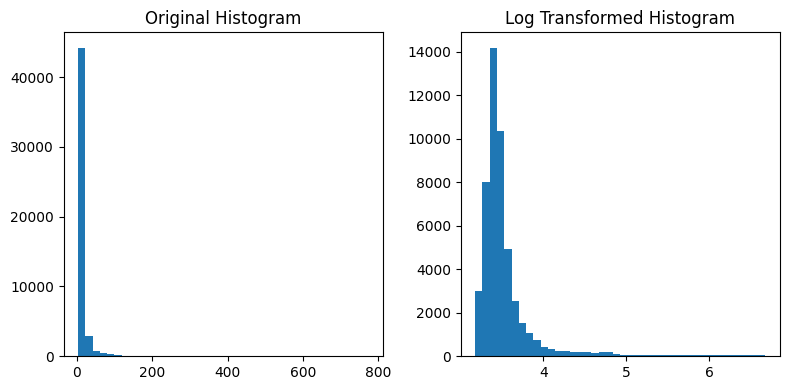

In [3]:
import time
import matplotlib.pyplot as plt

def plot_histograms_in_loop(images, channel=1):
    for img in images:
        fig = plt.figure(figsize=(8, 4))  # Set the figure size
        
        # First histogram
        plt.subplot(1, 2, 1)
        plt.hist(img[channel].ravel(), bins=40)
        plt.title('Original Histogram')

        # Second histogram with log transformation
        plt.subplot(1, 2, 2)
        plt.hist(np.log(img[channel].ravel() - global_min[channel] + 0.1), bins=40)
        plt.title('Log Transformed Histogram')
        
        plt.tight_layout()  # Adjust subplots to fit in to the figure area.
        plt.show()

        time.sleep(1)  # Pause for 1 second
        
        plt.close(fig)

# plot_histograms_in_loop(images)
plot_histograms_in_loop([average_image])